# Project: Python Data Analysis Project
##### Use your Python skills to explore a dataset and develop a narrative. Establish a research question and use tools such as NumPy, SciPy, Pandas, and visualization packages to answer the question in a business context.

Project is available in git repository https://github.com/RafZel/NYCDSA_Project_1.git

1. <a id='Section I - Data Analysis'>Data</a>
2. <a id='##SECTION_II'>Data II</a>

In [1]:
import os
import requests
import time
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Section_I
### Data Analysis
Under this section we will create two datasets, analyze and manipulate them

1. Dataset "beqom_logs_Oct.csv" contains application logs. How many times users log to the aplication <br>
Dataset is contain columns **'Passport', 'Endpoint', 'Tenant', 'Client', 'ConfigurationMode', 'Date', 'Details', 'IP'** <br>
- **Passport** - email address which is assigned to the application user 
- **Endpoint** - system tenant which user login. For this purpouse we will be analizing productive data only
- **Tenant** - database code
- **Client** - Company who is using application
- **ConfigurationMode** - what metod was used to access appliaction (e.g ExternalIdP(Google), ExternalIdP(JTI (Prod - SAML)))
- **Date** - date and time when application was accessed
- **Details** - detail url used to acess application
- **IP** - IP address used to access application

2. Dataset "bq_employees_05112021.csv" contian information about all application users Actice/Inactive registeres in the application. <br>
This data set was generated directly from the application database using sql query available [here](http://localhost:8888/doc/tree/OneDrive/NYC%20Data%20Science%20Academy%20-%202021/BootCamp2021/NYCDSA_Project_1/Data/Employee_query_03112021.sql)

Dataset contains columns **'id_user', 'code_payee', 'PersonNr', 'active', 'firstname_user', 'lastname_user', 'login_user', 'Company', 'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'JobTitle', 'id', 'id_rank', 'StartDate', 'EndDate'**

- **id_user** - internal application user identifier
- **code_payee** - external application user identifier. In this case it is SAP employee ID number. Employee can have only one employee ID 
- **PersonNr** - external application user identifier. In this case it is SAP employee number. Employee can have only many employee numbers
- **active** - information if user is active or inactive
- **firstname_user** - user first name
- **lastname_user** - user last name 
- **login_user** - user email address 
- **Company** - user company assignement
- **EmployeeGroup** - user group assignment 
- **EmployeeSubGroup** - user subgroup assignement 
- **PersonnelArea** - user personnel area assignement 
- **PersonnelSubArea** - user personel subarea assignement 
- **JobTitle** - user job title in the organization 
- **id** - user can have many orgasignements in period of time when he works for organization. Id and start date is used to identify last active record
- **id_rank** - we are identifing latest record
- **StartDate** - start date organizatinal assignment 
- **EndDate** - end date of organizational assignement


In [2]:
# Upload all application logs
# Upload all application users
df_logs_all = pd.read_csv('../NYCDSA_Project_1/Data/beqom_logs_Oct.csv')
df_application_users = pd.read_csv('../NYCDSA_Project_1/Data/bq_employees_05112021.csv')

In [8]:
# print(f'Application Logs -  {list(df_logs_all.columns)}')
# print(f'Application Users - {list(df_application_users.columns)}')

In [9]:
# df_application_users.head()
# df_logs_all.head()

### -- df_application_users
 - Identify number of application users by record rank
 - Identify datatypes in dataframe - Conclusion StartDate, EndDate should be converted to datetime object

In [17]:
print(df_application_users['id_rank'].value_counts())
print('*'*50)
print(df_application_users.dtypes)

1      36114
2      31492
3      25117
4      18732
5      12692
       ...  
83         1
82         1
81         1
80         1
103        1
Name: id_rank, Length: 103, dtype: int64
**************************************************
id_user               int64
code_payee            int64
PersonNr              int64
active               object
firstname_user       object
lastname_user        object
login_user           object
Company              object
EmployeeGroup        object
EmployeeSubGroup     object
PersonnelArea        object
PersonnelSubArea    float64
JobTitle             object
id                  float64
id_rank               int64
StartDate            object
EndDate              object
dtype: object


### -- df_logs_all
- Identify number of login to the applicaiton by application tenant
- Identify data types in datafreame  - Conclusion Date, should be converted to datetime object

In [18]:
print(df_logs_all['Tenant'].value_counts())
print('*'* 50)
print(df_logs_all.dtypes)

jti.9r1.prod.bqm       59436
JTI.9r1.dev.bqm        11344
jti.9r1.sit3.bqm        7597
jti.9r1.test.bqm        6079
jti.9r1.preprod.bqm     1436
jti.training-01         1205
jti.9r1.pentest.bqm      346
jti.9r1.preview.bqm      344
jti.preview-01           198
Name: Tenant, dtype: int64
**************************************************
Passport             object
Endpoint             object
Tenant               object
Client               object
ConfigurationMode    object
Date                 object
Details              object
IP                   object
dtype: object


### Select data that will be used in the future data manipluation
#### In this step we are selecting, analyzing and preparign data set for future merge

- Select from Application Logs data set only logs for productive tenant jti.9r1.prod.bqm
- Select from Application Users only last employee assignment
- Lower all valuses in ```df_prod['Passport']``` and ```df_user['login_user']``` ,<br>
this step is required to properly marge dataframes in the future
- Covert columns ```df_prod['Date']```, ```df_user['StartDate']```, ```df_user['EndDate']``` to date format to properly analyze data in the future

In [24]:
df_prod = df_logs_all.loc[df_logs_all['Tenant'] == 'jti.9r1.prod.bqm'].reset_index(drop=True)
# df_prod.head()

In [25]:
df_user = df_application_users.loc[df_application_users['id_rank'] == 1].reset_index(drop=True)
# df_user.head()

In [26]:
#lower sting in passpot column and in login_user
df_prod['Passport'] = df_prod['Passport'].str.lower()
df_user['login_user'] = df_user['login_user'].str.lower()

#convert Date column to date format
df_prod['Date'] = pd.to_datetime(df_prod['Date'], infer_datetime_format=True)
df_user['StartDate'] = pd.to_datetime(df_user['StartDate'], infer_datetime_format=True)
df_user['EndDate'] = pd.to_datetime(df_user['EndDate'], infer_datetime_format=True)
# df_prod = df_prod.applymap(lambda s: s.lower() if type(s) == str else s)
# df_prod.isnull().sum()

In [27]:
print(df_prod.dtypes)
print('*'*50)
print(df_user.dtypes)

Passport                     object
Endpoint                     object
Tenant                       object
Client                       object
ConfigurationMode            object
Date                 datetime64[ns]
Details                      object
IP                           object
dtype: object
**************************************************
id_user                      int64
code_payee                   int64
PersonNr                     int64
active                      object
firstname_user              object
lastname_user               object
login_user                  object
Company                     object
EmployeeGroup               object
EmployeeSubGroup            object
PersonnelArea               object
PersonnelSubArea           float64
JobTitle                    object
id                         float64
id_rank                      int64
StartDate           datetime64[ns]
EndDate             datetime64[ns]
dtype: object


In [30]:
# df_prod.head()

In [31]:
# df_user.head()

### Dataset analysis
#### At this point we are making decision which data keep which remove from dataset

##### Dataset ```df_user```

- Verify how many nuls we have in ```df_user``` dataset <br>
Conclusion - we identified two useres which accounts have been removed from the data source system (SAP HR)<br>
Those email addresses needs to be removed from dataset ```df_user``` <br>
From this point we are using ```df_user_1``` as main dataset for application useres <br>
*Removal step might not be requred in the future. Cearfully check this step next time when you will be generating user dataset from the system*

- check how many users do we have in the application who are not in @jti domain <br>
Conclusion. We don't need to remove any useres from dataset <br>
In the future worth to check emails:

##### Dataset ```df_prod```

- Check how many non jti employees access the system and analyze reason. <br>
New dataset ```df_prod_non_jti```whas created to analyze all non jti employees <br>
Conclusion:<br>
-- remove logs for users with @beqom domain those are developers working in our project <br>
```df_prod_1``` was created based on ```df_prod``` after removing @beqom users
-- remove logs for BTS P&C useres who are supporting the application <br>
```df_prod_2```was created after based on ```df_prod_1```after removing BTS P&C

In [36]:
print(df_user.isnull().sum())
df_user.loc[df_user['Company'].isnull()]
# If not null it means that some employees have been removed from SAP system but their accounts still exist in beqom

id_user                0
code_payee             0
PersonNr               0
active                 0
firstname_user         0
lastname_user          3
login_user             0
Company                2
EmployeeGroup          2
EmployeeSubGroup       2
PersonnelArea          2
PersonnelSubArea       2
JobTitle            3765
id                     2
id_rank                0
StartDate              2
EndDate                2
dtype: int64


,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
29147,87904,98497,98497,Yes,MATYLDA,GAJEWSKA,matylda.gajewska@jti.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,NaT
29614,178550,98896,98896,Yes,MIKHAIL,SEMIANIAKA,mikhail.semianiaka@jti.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,NaT


In [37]:
# This step is required only if in dataset df_user you will find null values. Data investigation shows that below email addresses 
# have been removed from source system (SAP HR) and data are not updated in beqom system
df_user_1 = df_user[~df_user['login_user'].isin(['mikhail.semianiaka@jti.com', 'matylda.gajewska@jti.com'])].reset_index(drop=True)

In [62]:
#Check how many users we have in the application who are not in @jti domain
df_user_non_jti = df_user_1[~df_user_1['login_user'].str.contains('@jti.com')].reset_index(drop=True)
df_user_non_jti['domain'] = df_user_non_jti['login_user'].str.split('@').str[1]
df_user_non_jti.groupby('domain')['login_user'].count()

domain
cpluspconsulting.com              1
jt.com                           67
jticorp.mail.onmicrosoft.com      1
tobaccoland.at                  153
truespirit.jp                     1
Name: login_user, dtype: int64

In [63]:
# Check how many times non jti employees log in to the system and analyse who it was
df_prod_non_jti = df_prod[~df_prod['Passport'].str.contains('@jti.com')].reset_index(drop=True)
df_prod[~df_prod['Passport'].str.contains('@jti.com')].count()

Passport             166
Endpoint             166
Tenant               166
Client               166
ConfigurationMode    166
Date                 166
Details              166
IP                   166
dtype: int64

In [67]:
# pd.set_option('display.max_rows', None)
# Conclusion:
# - remove users with @beqom domain those are developers working in our project
df_prod_non_jti.groupby('Passport').count()

,Endpoint,Tenant,Client,ConfigurationMode,Date,Details,IP
Passport,,,,,,,
aileen.moenning@tobaccoland.at,9,9,9,9,9,9,9
alfred.pekarz@tobaccoland.at,2,2,2,2,2,2,2
bartlomiej.kielech@beqom.com,17,17,17,17,17,17,17
doris.goettersdorfer@tobaccoland.at,4,4,4,4,4,4,4
franziska.haberl@tobaccoland.at,2,2,2,2,2,2,2
johannes.lumesberger@tobaccoland.at,1,1,1,1,1,1,1
katrin.zsacsek@tobaccoland.at,1,1,1,1,1,1,1
krzysztof.krzysik@beqom.com,13,13,13,13,13,13,13
manfred.knapp@tobaccoland.at,2,2,2,2,2,2,2


In [17]:
# Check how many non jti useres we have in the system and why?
df_user_non_jti = df_user[~df_user['login_user'].str.contains('@jti.com')].reset_index(drop=True)
df_user[~df_user['login_user'].str.contains('@jti.com')].count()

id_user             223
code_payee          223
PersonNr            223
active              223
firstname_user      223
lastname_user       223
login_user          223
Company             223
EmployeeGroup       223
EmployeeSubGroup    223
PersonnelArea       223
PersonnelSubArea    223
JobTitle            195
id                  223
id_rank             223
StartDate           223
EndDate             223
dtype: int64

In [74]:
# remove developers from statistics by creating new df
# df_prod.drop(df_prod.loc[df_prod['Passport'].str.contains('@beqom.com')].index, inplace=True)

print(df_prod[df_prod['Passport'].str.contains('@beqom.com')].count())
print('*'*50)
df_prod_1 = df_prod[~df_prod['Passport'].str.contains('@beqom.com')].reset_index(drop=True)
print(f"Total number of all logins {df_prod['Passport'].count()}")
print('*'*50)
print(f"Total number of all logins after removing users @beqom.com {df_prod_1['Passport'].count()}")
print(f"Number removed records {df_prod['Passport'].count() - df_prod_1['Passport'].count()} ")

Passport             125
Endpoint             125
Tenant               125
Client               125
ConfigurationMode    125
Date                 125
Details              125
IP                   125
dtype: int64
**************************************************
Total number of all logins 59436
**************************************************
Total number of all logins after removing users @beqom.com 59311
Number removed records 125 


In [ ]:
print(df_prod_1.loc[df_prod_1['Passport'].str.contains('@beqom.com')].count())
print(df_prod_1.count())
df_prod_1.head()

In [69]:
# Check who else should be removed from data set.
# - Conclusion Exclude BTS P&C useres from Application Log PRD
df_prod[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

,Passport,Count
5109,krzysztof.krzywosz@jti.com,706
428,alexey.chernyshov@jti.com,510
3837,iqbal.satrionindito@jti.com,492
8229,sergii.postnyi@jti.com,485
355,alexander.rudnitskiy@jti.com,468
...,...,...
5052,konstantin.andrusenko@jti.com,1
1391,brandina.mwale@jti.com,1
1390,bram.kamphuis@jti.com,1
5051,konstantin.aksenov@jti.com,1


In [78]:
# Exclude BTS P&C useres from Application Log PRD
# krzysztof.krzywosz@jti.com (706), rafal.zelazny@jti.com (260), adam.miron@jti.com (333), beata.kropop@jti.com (107)
df_prod_2 = df_prod_1[~df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].reset_index(drop=True)
# df_prod_3.loc[df_prod_3['Passport'] == 'krzysztof.krzywosz@jti.com']
print(f"Total number of login before BTS P&C removal: {df_prod_1['Passport'].count()}")
print(f"Total number of login after BTS P&C removal: {df_prod_2['Passport'].count()}")
print(f"Total number removed records: {df_prod_1['Passport'].count() - df_prod_2['Passport'].count()}")
print(f"Total number of records generated by BTS P&C {df_prod_1['Passport'][df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].count()}")
print(f"Final check. Total number removed login records equal Total number of login records generated by BTS P&C === {(df_prod_1['Passport'].count() - df_prod_2['Passport'].count()) == (df_prod_1['Passport'][df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].count())} ")


Total number of login before BTS P&C removal: 59311
Total number of login after BTS P&C removal: 57905
Total number removed records: 1406
Total number of records generated by BTS P&C 1406
Final check. Total number removed login records equal Total number of login records generated by BTS P&C === True 


### Dataset merge
#### At this stage we are preparing for marging two datasets
The subject of marge is ```df_prod_3```with all productive logs and ```df_user_1``` with all application users

- Create ```df_prod_3``` based on ```df_prod_2``` and we are selecting only columns 'Passport', 'Date', 'IP'
- Check ```df_user_1``` before marge
- marge dataset ```df_prod_3``` with ```df_user_1```and save output in ```df_prod_user``` <br>
<br>
**Conclusion**
At this stage of marging two datasets we identified that not all data were mareged correctly <br>
Additional analysis is required to clean up datasets

In [88]:
#Preapration for dataframe marge.
# Create new dataframe from df_prod_logs
df_prod_3 = df_prod_2[['Passport','Date','IP']].copy()

In [89]:
#Dataset check how many records
print(df_prod_3['Passport'].count())
print('*'*50)
# df_prod_3.head()

57905
**************************************************


In [90]:
#Dataset df_user_1 check
print(df_user_1['login_user'].count())
print('*'*50)
# df_user.head()

36112
**************************************************


In [91]:
# merge dataframe_prod_user with dataframe logs where we store application logs 
# as a result we will recive dataframe where users who are access application will match to application useres
df_prod_user = df_prod_3.merge(df_user_1, left_on='Passport',right_on='login_user', how='left')

In [101]:
# Result of this marge shows that some useres who access application in the past didn't match to current numbers of user in the system.
# Main reason for that is users changed their corporate emails addresses for some reasons like: speling in email address, marige - last name change
print('*'*50)
print(f"{df_prod_user['Passport'].count() - df_prod_user['login_user'].count()} application login records does not match to the application useres")
print('*'*50)
print('Conclusion: identify all non matching application logs and compare with application users. Probably users changed their email addreses')
# print(df_prod_user.isnull().sum())

**************************************************
981 application login records does not match to the application useres
**************************************************
Conclusion: identify all non matching application logs and compare with application users. Probably users changed their email addreses


### Dataset analysis after merge

#### We need to verify why data was not fully marged

- we are creating ```missing_users```dataset based on  marged dataset ```df_prod_user``` to identify those who does not marged properly <br>
- conclusion after emial analysis is that all 95 users changed their corporate email addresses from diferent reasons (marige, speling error, other) <br>
because of that we need to introduce new dataset which will be used to replace old email addresses to new one <br>
we need to change email addresses for 95 users in dataset ```df_prod_3```
- ```df_email_change```contain old and new email addresses that needs to be replaced <br>
based on ```df_email_change``` we are creating dictionary which will be used for email replacment
- data replacment will happen in new copy of current dataset <br>
Dataset ```df_prod_4``` now replace ```df_prod_3```
- Final dataset after cleaning all emails is ```df_prod_5```


In [109]:
#Conclusion we ideitified 95 users who changed their email addresses
missing_users = df_prod_user.loc[df_prod_user['id_user'].isnull()]
missing_users.groupby('Passport').count().count()

Date                95
IP                  95
id_user             95
code_payee          95
PersonNr            95
active              95
firstname_user      95
lastname_user       95
login_user          95
Company             95
EmployeeGroup       95
EmployeeSubGroup    95
PersonnelArea       95
PersonnelSubArea    95
JobTitle            95
id                  95
id_rank             95
StartDate           95
EndDate             95
dtype: int64

In [110]:
# New data frame with all useres where we need to replace email adresses
# Before we marge df_prod_user with df_prod_3 we need to replace below emials in df_prod_3 from old to new emails
df_email_change = pd.read_csv('../NYCDSA_Project_1/Data/email_change.csv')
df_email_change['new_email'] = df_email_change['new_email'].str.lower()

In [112]:
# df_email_change.tail(20)

In [113]:
# Create dictionary
emails_to_change_dict = pd.Series(df_email_change['new_email'].values, index=df_email_change['old_email']).to_dict()
# emails_to_change_dict

In [115]:
# df_prod_3[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

In [116]:
#Preparation for data replacment. Copy of dataset is created
df_prod_4 = df_prod_3.copy()

In [119]:
#Verify how many useres needs to be replaced in dataset
print(f" Users who login to the application with old email: {df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['old_email'])].count()}")
print(f" Users who log in to the aplication after changed changed email (new email): {df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['new_email'])].count()}")
print(f" Number of unique new email addresses {len(df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['new_email'])].unique())}")

 Users who login to the application with old email: 981
 Users who log in to the aplication after changed changed email (new email): 79
 Number of unique new email addresses 24


In [120]:
# #Additional verification step
# # New email address
# print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.klinikowska@jti.com'])
# # Old email address 
# print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.luberadzka@jti.com'])

In [121]:
# We change all old email addresses to new emails in prod log file
df_prod_4 = df_prod_4.replace({'Passport': emails_to_change_dict})

In [123]:
# # Check on one example how it works
# # New email address
# print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.klinikowska@jti.com'])
# # Old email address 
# print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.luberadzka@jti.com'])

In [125]:
# Check corrected dataframe
# df_prod_4[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

In [126]:
# There are some unidentified emails in email_change csv which at the moment replace email with remove
# Check how many records we have and remove them
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'remove'].count())
# Final prod logs dataframe before marge
df_prod_5 = df_prod_4[~df_prod_4['Passport'].str.contains('remove')].reset_index(drop=True)

13


In [127]:
# Check if one uniqe passport has been removed -- remove
print(df_prod_4[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False).count())
print(df_prod_5[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False).count())

Passport    9676
Count       9676
dtype: int64
Passport    9675
Count       9675
dtype: int64


In [128]:
print(df_prod_5['Passport'].count())
print(df_prod_1['Passport'].count())

57892
59311


### Second dataset merge
#### After final dataset cleaning we are marging datasets one more time

- marge dataset ```df_prod_5``` with ```df_user_1```and save output in ```df_prod_user_1```
- Result of this marge shows that all went well no additional data check is requred. <br>
The only missing data are "Job Title"information which is ok as this information might not exist in main system.


In [129]:
# Repeat merge excercise
# merge dataframe_prod_user with dataframe logs where we store application logs 
# as a result we will recive dataframe where users who are access application will match to application useres
df_prod_user_1 = df_prod_5.merge(df_user_1, left_on='Passport',right_on='login_user', how='left')

In [131]:
print(df_prod_user_1.isnull().sum())

Passport               0
Date                   0
IP                     0
id_user                0
code_payee             0
PersonNr               0
active                 0
firstname_user         0
lastname_user          0
login_user             0
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
JobTitle            3618
id                     0
id_rank                0
StartDate              0
EndDate                0
dtype: int64


In [133]:
# df_prod_user_1

In [136]:
## Check if we have any useres without PersonNr
# df_prod_user_1.loc[df_prod_user_1['PersonNr'].isnull()]

### Preparation for collecting detail infromation about IP address
#### In this step we will take marged dataset and use it collect detail inforamtion about IP address
- verify columns which will be used to create new dataset
- create new dataset ```df_prod_user_2```which will be used for future data analysis
- identify unique IP addresses in dataset ```df_prod_user_2```and create list form it <br>
- based on unique IP address get specific location we will collect detail information about IP address <br>
#### To get specific location we use API point http://ip-api.com/batch <br>
When building request you need to take into consideration <br>
1.  A request needs to formatted as a JSON array, containing up to 100 IP addresses or objects.
2.  This endpoint is limited to 15 requests per minute from an IP address. --> 60s/15 = 4 times per minute <br>

- Split list ```unique_ip``` to equal 100 elements following API requirements <br>
New list will be created for this ```unique_ip_split```
- create new dataframe based on the API results ```df_country_ip``` additionaly we are saving dataframe as csv file


In [137]:
df_prod_user_1.columns

Index(['Passport', 'Date', 'IP', 'id_user', 'code_payee', 'PersonNr', 'active',
       'firstname_user', 'lastname_user', 'login_user', 'Company',
       'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea',
       'PersonnelSubArea', 'JobTitle', 'id', 'id_rank', 'StartDate',
       'EndDate'],
      dtype='object')

In [139]:
df_prod_user_2 = df_prod_user_1[['id_user','code_payee','PersonNr','firstname_user','lastname_user','login_user','JobTitle','Company', 'EmployeeGroup', 'EmployeeSubGroup','PersonnelArea','PersonnelSubArea','active','IP','Date']].copy()

In [141]:
#Identify number of uniqe IP addresses
print(f"Total number of IP addresses {df_prod_user_3['IP'].count()}")
unique_ip = df_prod_user_2['IP'].unique().tolist()
print(f"Total number of UNIQUE IP addresses {len(unique_ip)}")

Total number of IP addresses 57897
Total number of UNIQUE IP addresses 15068


In [142]:
# split list unique_ip to lists containing 100 elements only
number_elements = 100
unique_ip_split = [ unique_ip[ip_element:ip_element + number_elements] for ip_element in range(0, len(unique_ip), number_elements)]

In [143]:
len(unique_ip_split)

151

In [144]:
url = "http://ip-api.com/batch"
response_dict = []
counter = 0
total_start_time = time.time()
total_end_time = time.time()

for item in range(0, len(unique_ip_split)):
    time_start = time.perf_counter()
    params = unique_ip_split[item]
    response = requests.post(url=url, json=params).json()
#     print(len(response))
    for element in response:
        response_dict.append(element)
    time_end = time.perf_counter()
    if counter in range(1, 200, 10):
        print(f'Time to get one set of data from ip-api round {counter} total time {total_end_time - total_start_time:0.4f} seconds')
#         print(f'Time to get one set of data from ip-api {time_end - time_start:0.4f} seconds')
    time.sleep(5)
    total_start_time += time_start
    total_end_time  += time_end
    counter += 1

Time to get one set of data from ip-api round 1 total time 0.2649 seconds
Time to get one set of data from ip-api round 11 total time 2.0469 seconds
Time to get one set of data from ip-api round 21 total time 4.1496 seconds
Time to get one set of data from ip-api round 31 total time 5.8538 seconds
Time to get one set of data from ip-api round 41 total time 7.6197 seconds
Time to get one set of data from ip-api round 51 total time 9.5970 seconds
Time to get one set of data from ip-api round 61 total time 11.3796 seconds
Time to get one set of data from ip-api round 71 total time 13.2029 seconds
Time to get one set of data from ip-api round 81 total time 14.8717 seconds
Time to get one set of data from ip-api round 91 total time 16.6161 seconds
Time to get one set of data from ip-api round 101 total time 18.4292 seconds
Time to get one set of data from ip-api round 111 total time 20.1891 seconds
Time to get one set of data from ip-api round 121 total time 21.9071 seconds
Time to get one 

In [145]:
print(f"Total number of UNIQUE IP addresses before API run {len(unique_ip)}")
print(f"Total number of UNIQUE IP addresses after API run {len(response_dict)}")

Total number of UNIQUE IP addresses before API run 15068
Total number of UNIQUE IP addresses after API run 15068


In [146]:
#Create datafram based on data recived from API
df_country_ip = pd.DataFrame(response_dict)

In [147]:
# Save API results as csv file.
# This API take some time so you don't have to run it every time. Take data from csv if you have to repeat action
df_country_ip.to_csv('../NYCDSA_Project_1/Data/ip_details_07112021.csv')

In [148]:
# check if we have any faild IP recogntion
df_country_ip.loc[df_country_ip['status'] != 'success'].count()

status         0
country        0
countryCode    0
region         0
regionName     0
city           0
zip            0
lat            0
lon            0
timezone       0
isp            0
org            0
as             0
query          0
dtype: int64

### Marge IP details dataframe with application log dataframe


- marge dataset application data log ```df_prod_user_2```with detail infromation about IP address ```df_country_ip``` <br>
final result of this step is dataset ```df_prod_user_3```

In [150]:
df_prod_user_3 = df_prod_user_2.merge(df_country_ip, left_on='IP',right_on='query', how='left')

In [151]:
#Verify data after merge
# df_prod_user_4.isnull().sum()

In [152]:
df_prod_4.count()

Passport    57905
Date        57905
IP          57905
dtype: int64

### Add additional data about entieties add to dataset

#### In this step we are adding additional information about entiety where user work to properly identify user in the future
- create new dataset ```df_entity```based on entity detail information
- marge ```df_entity``` with ```df_prod_user_3``` and save output in ```df_prod_user_4```

In [159]:
df_entity = pd.read_csv('../NYCDSA_Project_1/Data/Entities.csv')

In [160]:
# df_entity

In [161]:
#Check nulls to remove them
df_entity.isnull().sum()

CompanyCode    1
Entity Name    0
Country        2
Region         3
dtype: int64

In [162]:
# One company code needs to be removed
df_entity.loc[df_entity['CompanyCode'].isnull()]

,CompanyCode,Entity Name,Country,Region
122,NaN,JTI Kazakhstan LLC (Tajikistan Republic Repres...,Tajikistan,Eastern Europe


In [163]:
df_entity = df_entity.dropna(subset=['CompanyCode'])

In [164]:
# df_entity.loc[df_entity['CompanyCode'].isnull()]

In [165]:
df_prod_user_4 = df_prod_user_3.merge(df_entity, left_on='Company',right_on='CompanyCode', how='left')

In [171]:
# df_prod_user_4.isnull().sum()

In [168]:
# Check why we have missing records
empty_company = df_prod_user_4.loc[df_prod_user_4['Country'].isnull()]

In [169]:
# Justification for missing data
# Both entities HRXX and JTCH does not have Country or Region assignement
empty_company.groupby('Company')['code_payee'].count()

Company
HRXX    378
JTCH      4
Name: code_payee, dtype: int64

### Creating final data set that we use for data analysis

- based on dataset ```df_prod_user_4``` we are creating final dataset that we use for graphs

**Output for this section is ```df_final``` created**

In [173]:
#Create final dataset which will be used for presentation
print(df_prod_user_4.columns)
# df_prod_user_4.head()

Index(['id_user', 'code_payee', 'PersonNr', 'firstname_user', 'lastname_user',
       'login_user', 'JobTitle', 'Company', 'EmployeeGroup',
       'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'active', 'IP',
       'Date', 'status', 'country', 'countryCode', 'region', 'regionName',
       'city', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as', 'query',
       'CompanyCode', 'Entity Name', 'Country', 'Region'],
      dtype='object')


In [174]:
df_final = df_prod_user_4[['id_user', 'code_payee', 'PersonNr', 'firstname_user', 'lastname_user', 'login_user', 'JobTitle', 'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'active', 'Company', 'Entity Name', 'Country', 'Region', 'Date', 'IP', 'regionName',
       'city', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as']].copy().reset_index(drop=True)

In [175]:
df_final.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
firstname_user         0
lastname_user          0
login_user             0
JobTitle            3618
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
active                 0
Company                0
Entity Name            0
Country              382
Region               390
Date                   0
IP                     0
regionName             0
city                   0
zip                    0
lat                    0
lon                    0
timezone               0
isp                    0
org                    0
as                     0
dtype: int64

## SECTION_II 

### Reporting

### Analyze number of users in the application per Entity (Active, Inactive, Total)

To analyse application users we will use dataset ```df_user_1```that represent all application users and ```df_entity```that represents inforamtion about entities

In [181]:
df_company_users = df_user_1[['Company','code_payee','active']].copy()

In [182]:
df_company_users_1 = df_company_users.groupby(['Company', 'active'])['code_payee'].count().unstack()
df_company_users_1 = df_company_users_1.reset_index()

In [185]:
# df_company_users_1

In [186]:
df_company_users_1 = df_company_users_1.fillna(0)

#Create new column Number of all employees Active and Inactive
df_company_users_1['Total'] = df_company_users_1['No'] + df_company_users_1['Yes']
df_company_users_1 = df_company_users_1.sort_values('Total', ascending=False)

In [187]:
#Marge datasets to get detail information about entity 
df_company_users_1 = df_company_users_1.merge(df_entity, left_on='Company',right_on='CompanyCode', how='left').drop(columns='CompanyCode')

In [188]:
#Change dataset layout and rename columns
df_company_users_1 = df_company_users_1[['Company', 'Entity Name', 'Country', 'Region', 'Yes', 'No', 'Total']]
df_company_users_1.rename(columns={'Yes': 'Active Users', 'No':'Inactive Users', 'Total':'Total Number of Users'}, inplace=True)
# df_company_users_1.head(30)

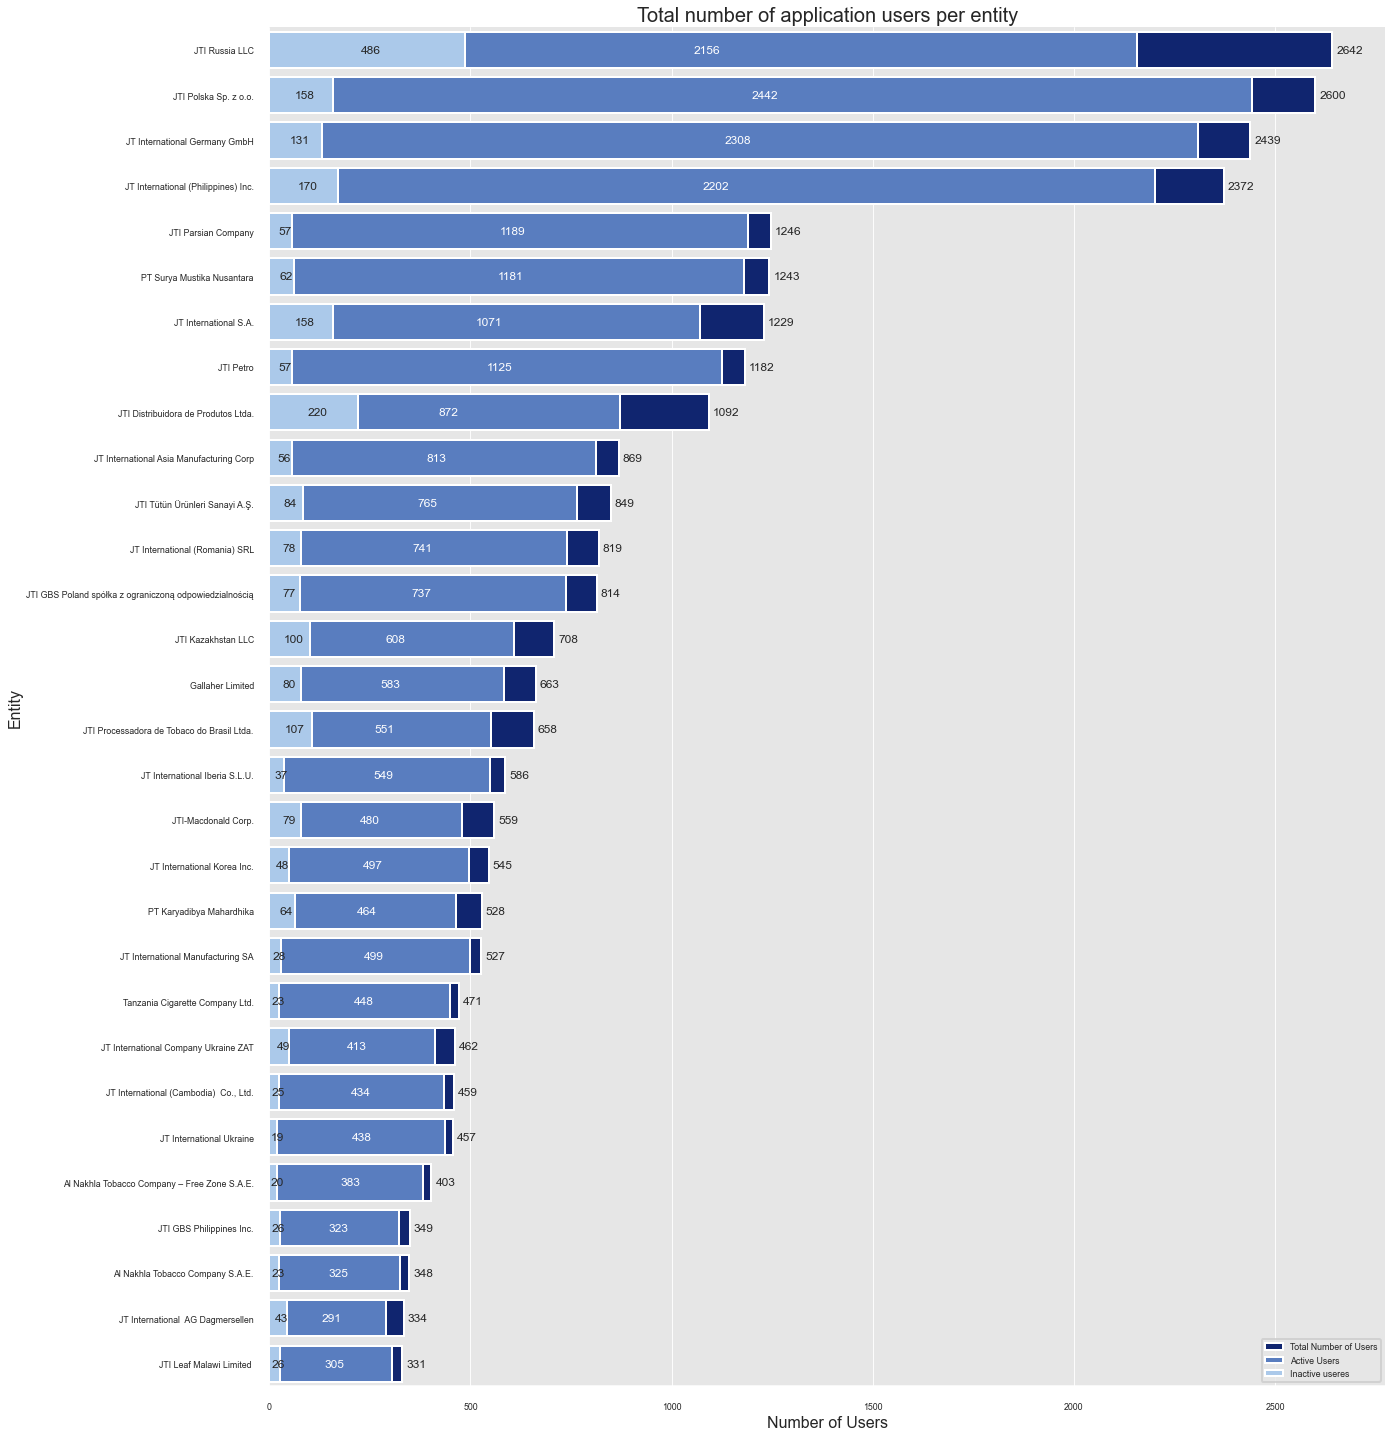

In [207]:
# Users per entity
df_company_users_1.head(25)
fig, ax = plt.subplots(figsize=(20,25))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("poster", font_scale = .4, rc={"grid.linewidth": 0.9})

s1 = sns.set_color_codes('dark')
s1 = sns.barplot(x = 'Total Number of Users', y = 'Entity Name', data=df_company_users_1.head(30), label='Total Number of Users', color='b')

s2 = sns.set_color_codes('muted')
s2 = sns.barplot(x = 'Active Users', y = 'Entity Name', data=df_company_users_1.head(30), label='Active Users', color='b')

s3 = sns.set_color_codes('pastel')
s3 = sns.barplot(x = 'Inactive Users', y = 'Entity Name', data=df_company_users_1.head(30), label='Inactive useres', color='b')

ax.bar_label(ax.containers[0], fmt='%.0f', padding=4, fontsize=12)
ax.bar_label(ax.containers[1], fmt='%.0f', label_type='center', padding=4, fontsize=12, color='w')
ax.bar_label(ax.containers[2], fmt='%.0f', label_type='center', padding=4, fontsize=12)

ax.set_title('Total number of application users per entity', fontsize=20)
ax.set_ylabel('Entity', fontsize=16)
ax.set_xlabel('Number of Users', fontsize=16)
ax.legend(ncol=1, loc="best", frameon=True)
sns.despine(left=True)

### Analyze number of users in the application per Country (Active, Inactive, Total)

In [191]:
df_company_users_country = df_company_users_1.groupby(['Country'])[['Active Users', 'Inactive Users', 'Total Number of Users']].sum().sort_values('Total Number of Users', ascending=False)
df_company_users_country = df_company_users_country.reset_index()
# df_company_users_country.loc[df_company_users_country['Country']== 'Switzerland']

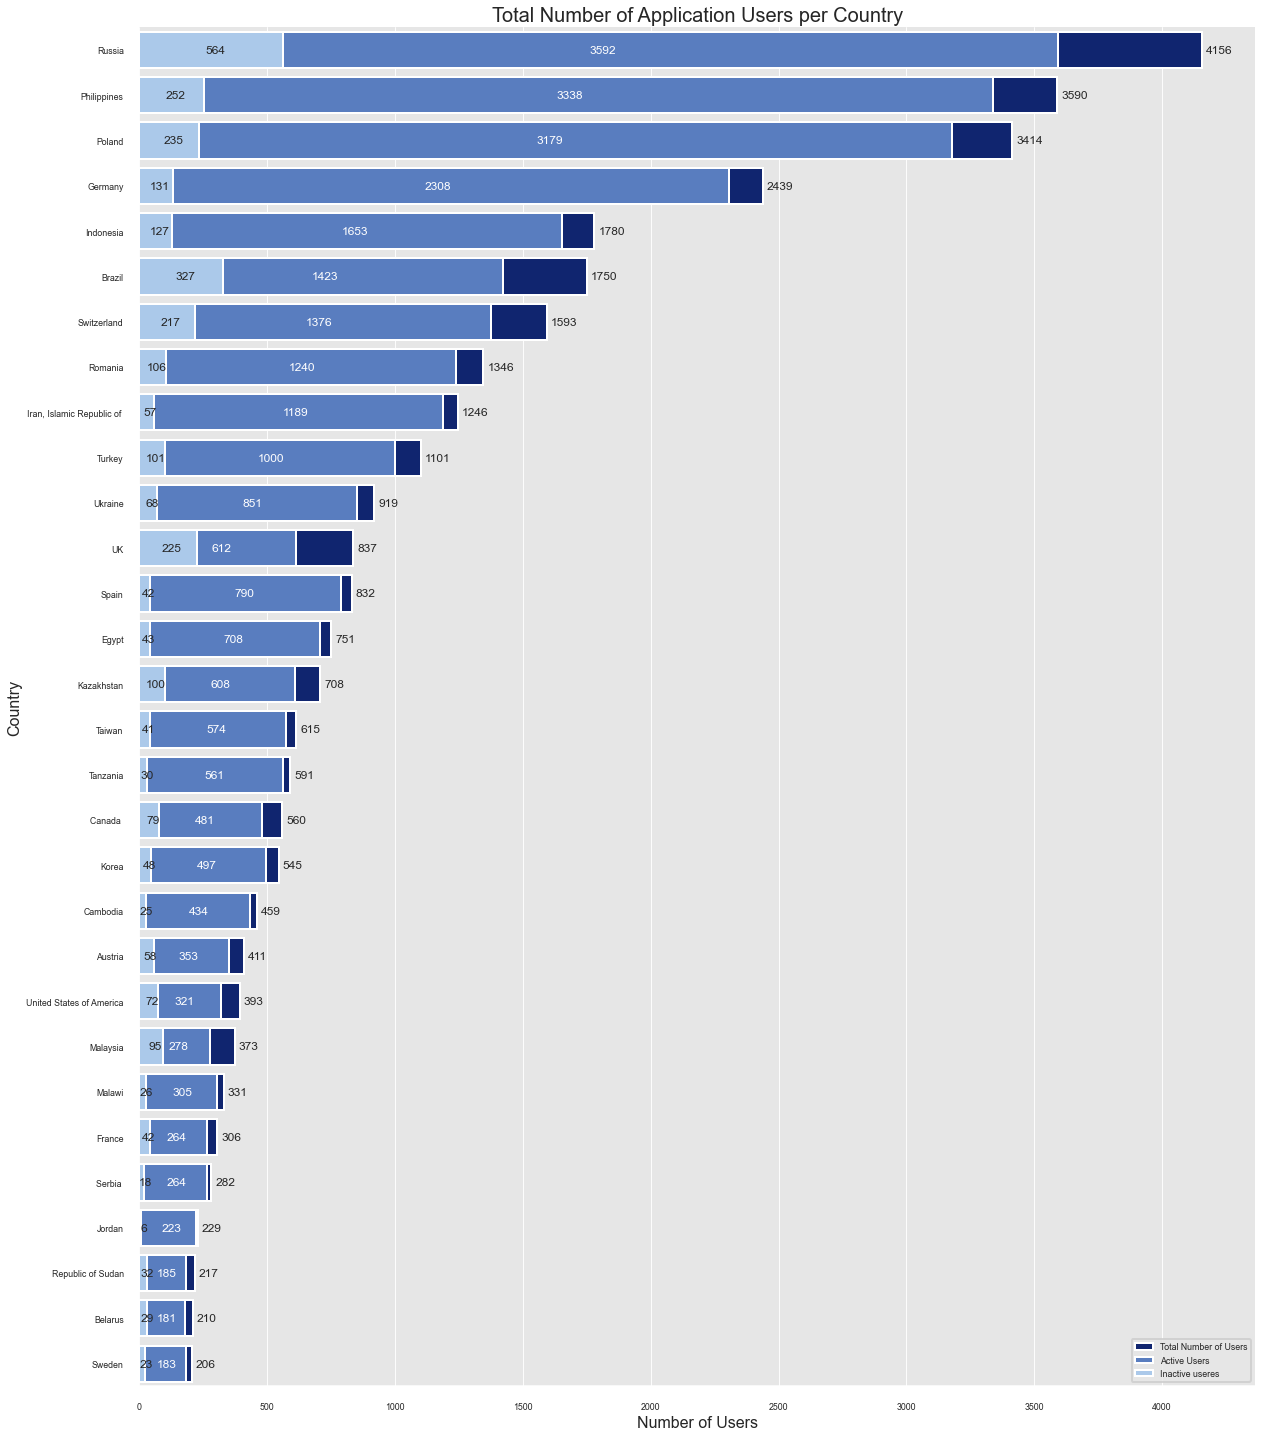

In [208]:
fig1, ax = plt.subplots(figsize=(20,25))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("poster", font_scale = .4, rc={"grid.linewidth": 0.9})

s1 = sns.set_color_codes('dark')
s1 = sns.barplot(x = 'Total Number of Users', y = 'Country', data=df_company_users_country.head(30), label='Total Number of Users', color='b')

s2 = sns.set_color_codes('muted')
s2 = sns.barplot(x = 'Active Users', y = 'Country', data=df_company_users_country.head(30), label='Active Users', color='b')

s3 = sns.set_color_codes('pastel')
s3 = sns.barplot(x = 'Inactive Users', y = 'Country', data=df_company_users_country.head(30), label='Inactive useres', color='b')

ax.bar_label(ax.containers[0], fmt='%.0f', padding=4, fontsize=12)
ax.bar_label(ax.containers[1], fmt='%.0f', label_type='center', padding=4, fontsize=12, color='w')
ax.bar_label(ax.containers[2], fmt='%.0f', label_type='center', padding=4, fontsize=12)

ax.set_title('Total Number of Application Users per Country', fontsize=20)
ax.set_ylabel('Country', fontsize=16)
ax.set_xlabel('Number of Users', fontsize=16)
ax.legend(ncol=1, loc="best", frameon=True)
sns.despine(left=True)

### Analyze number of active users in the application per Country (version 1)

In [194]:
# Create dataset that will show how application number of entires per country
df_company_users_country_trafic = df_final.groupby('Country')['login_user'].count()
df_company_users_country_trafic = df_company_users_country_trafic.reset_index()
df_company_users_country_trafic.sort_values('login_user', ascending=False, inplace=True)
df_company_users_country_trafic.reset_index(drop=True, inplace=True)

In [195]:
df_company_users_country_trafic.head()

,Country,login_user
0,Switzerland,7205
1,Poland,6242
2,Russia,4643
3,Philippines,4627
4,Ukraine,3249


In [196]:
#We marge this datase to recive information about active, inactive, total application useres together with number how many times aplication was access in the country
df_company_users_country_1 = df_company_users_country.merge(df_company_users_country_trafic, left_on='Country', right_on='Country', how='left')

In [197]:
df_company_users_country_1.head()

,Country,Active Users,Inactive Users,Total Number of Users,login_user
0,Russia,3592.0,564.0,4156.0,4643.0
1,Philippines,3338.0,252.0,3590.0,4627.0
2,Poland,3179.0,235.0,3414.0,6242.0
3,Germany,2308.0,131.0,2439.0,2835.0
4,Indonesia,1653.0,127.0,1780.0,274.0


In [198]:
df_company_users_country_1.fillna({'login_user':0}, inplace=True)

In [199]:
df_company_users_country_1.loc[df_company_users_country_1['login_user'].isnull()]

,Country,Active Users,Inactive Users,Total Number of Users,login_user


In [200]:
df_company_users_country_1

,Country,Active Users,Inactive Users,Total Number of Users,login_user
0,Russia,3592.0,564.0,4156.0,4643.0
1,Philippines,3338.0,252.0,3590.0,4627.0
2,Poland,3179.0,235.0,3414.0,6242.0
3,Germany,2308.0,131.0,2439.0,2835.0
4,Indonesia,1653.0,127.0,1780.0,274.0
...,...,...,...,...,...
70,Israel,13.0,2.0,15.0,95.0
71,Bosnia and Herzegovina,11.0,1.0,12.0,2.0
72,China,10.0,0.0,10.0,29.0
73,Kosovo,6.0,0.0,6.0,3.0


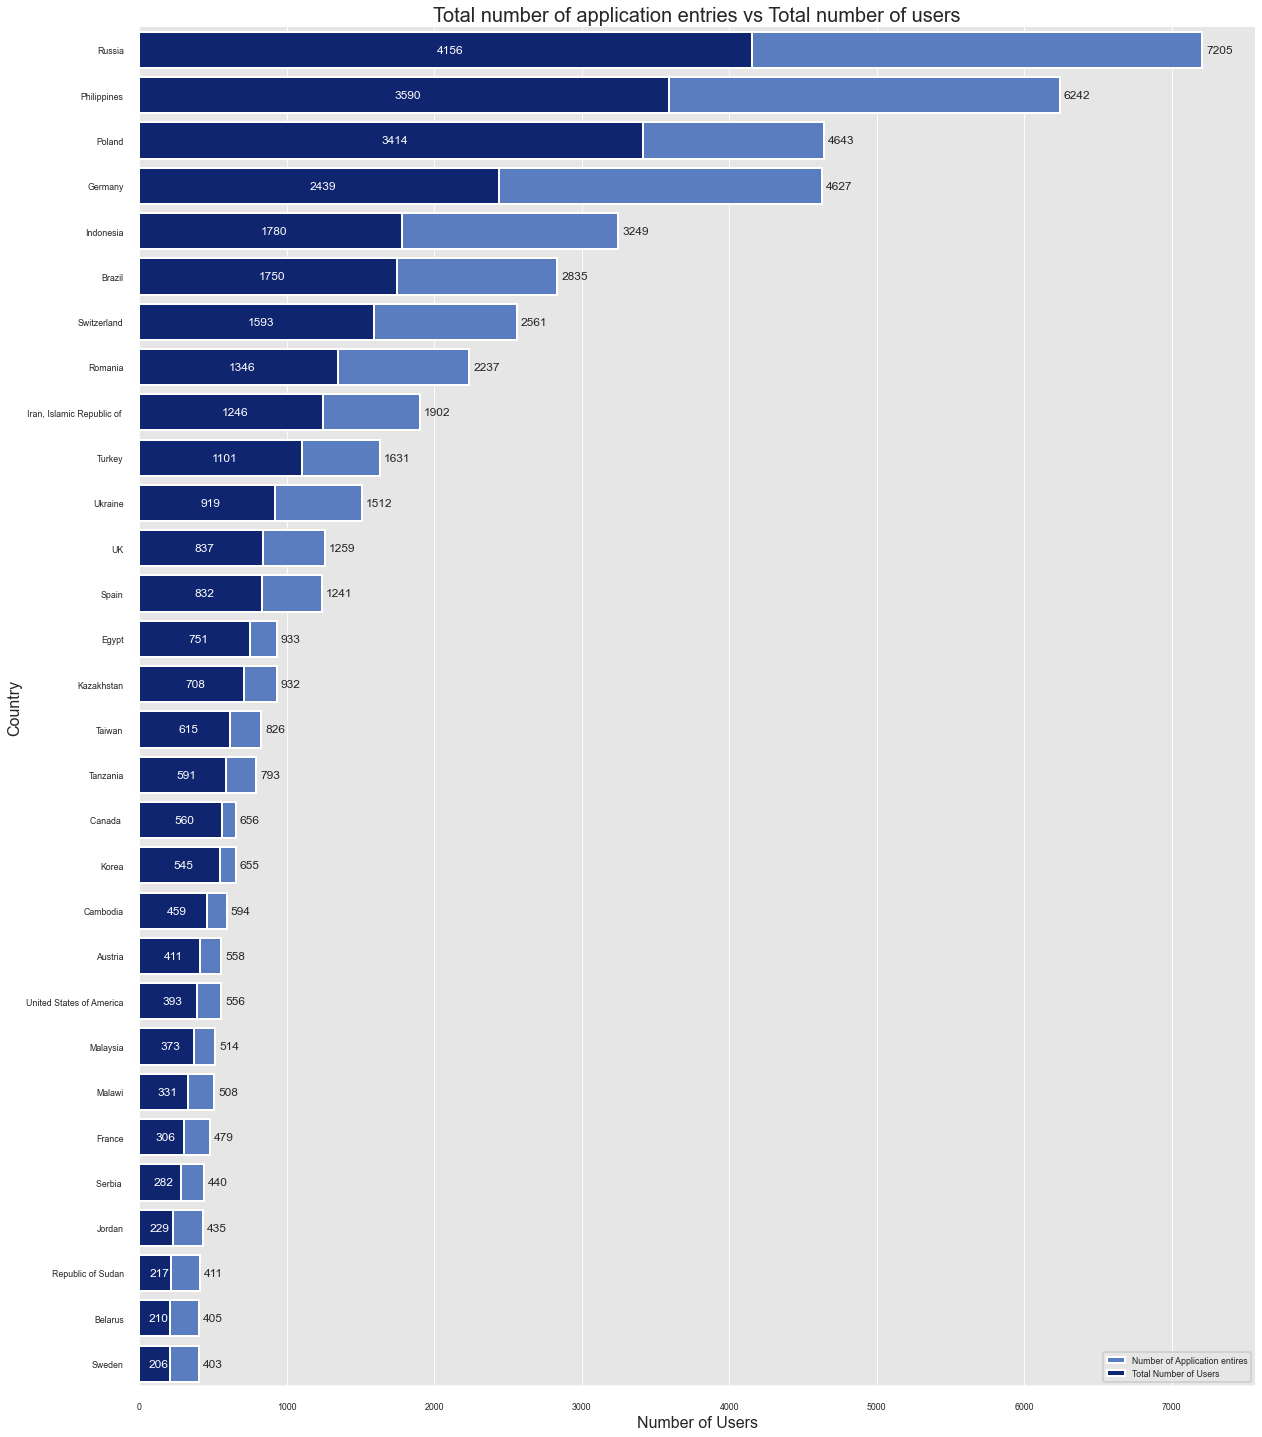

In [209]:
#Graph Total application trafic vs Total number of useres
fig1, ax = plt.subplots(figsize=(20,25))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("poster", font_scale = .4, rc={"grid.linewidth": 0.9})

s2 = sns.set_color_codes('muted')
s2 = sns.barplot(x = 'login_user', y = 'Country', data=df_company_users_country_1.sort_values('login_user', ascending=False).head(30), label='Number of Application entires', color='b')

s1 = sns.set_color_codes('dark')
s1 = sns.barplot(x = 'Total Number of Users', y = 'Country', data=df_company_users_country_1.head(30), label='Total Number of Users', color='b')

ax.bar_label(ax.containers[0], fmt='%.0f', padding=4, fontsize=12)
ax.bar_label(ax.containers[1], fmt='%.0f', label_type='center', padding=4, fontsize=12, color='w')

ax.set_title('Total number of application entries vs Total number of users', fontsize=20)
ax.set_ylabel('Country', fontsize=16)
ax.set_xlabel('Number of Users', fontsize=16)
ax.legend(ncol=1, loc="best", frameon=True)
sns.despine(left=True)

### Analyze number of active users in the application per Country (version 2)

In [211]:
df_company_users_country_1.rename(columns={'Total Number of Users':'Number of Users', 'login_user':'Application Entries'}, inplace=True)

In [212]:
df_company_users_country_1.head()

,Country,Active Users,Inactive Users,Number of Users,Application Entries
0,Russia,3592.0,564.0,4156.0,4643.0
1,Philippines,3338.0,252.0,3590.0,4627.0
2,Poland,3179.0,235.0,3414.0,6242.0
3,Germany,2308.0,131.0,2439.0,2835.0
4,Indonesia,1653.0,127.0,1780.0,274.0


In [213]:
df_company_users_country_2 = df_company_users_country_1.sort_values('Application Entries', ascending=False).head(30).melt(id_vars='Country', value_vars=['Number of Users','Application Entries'])

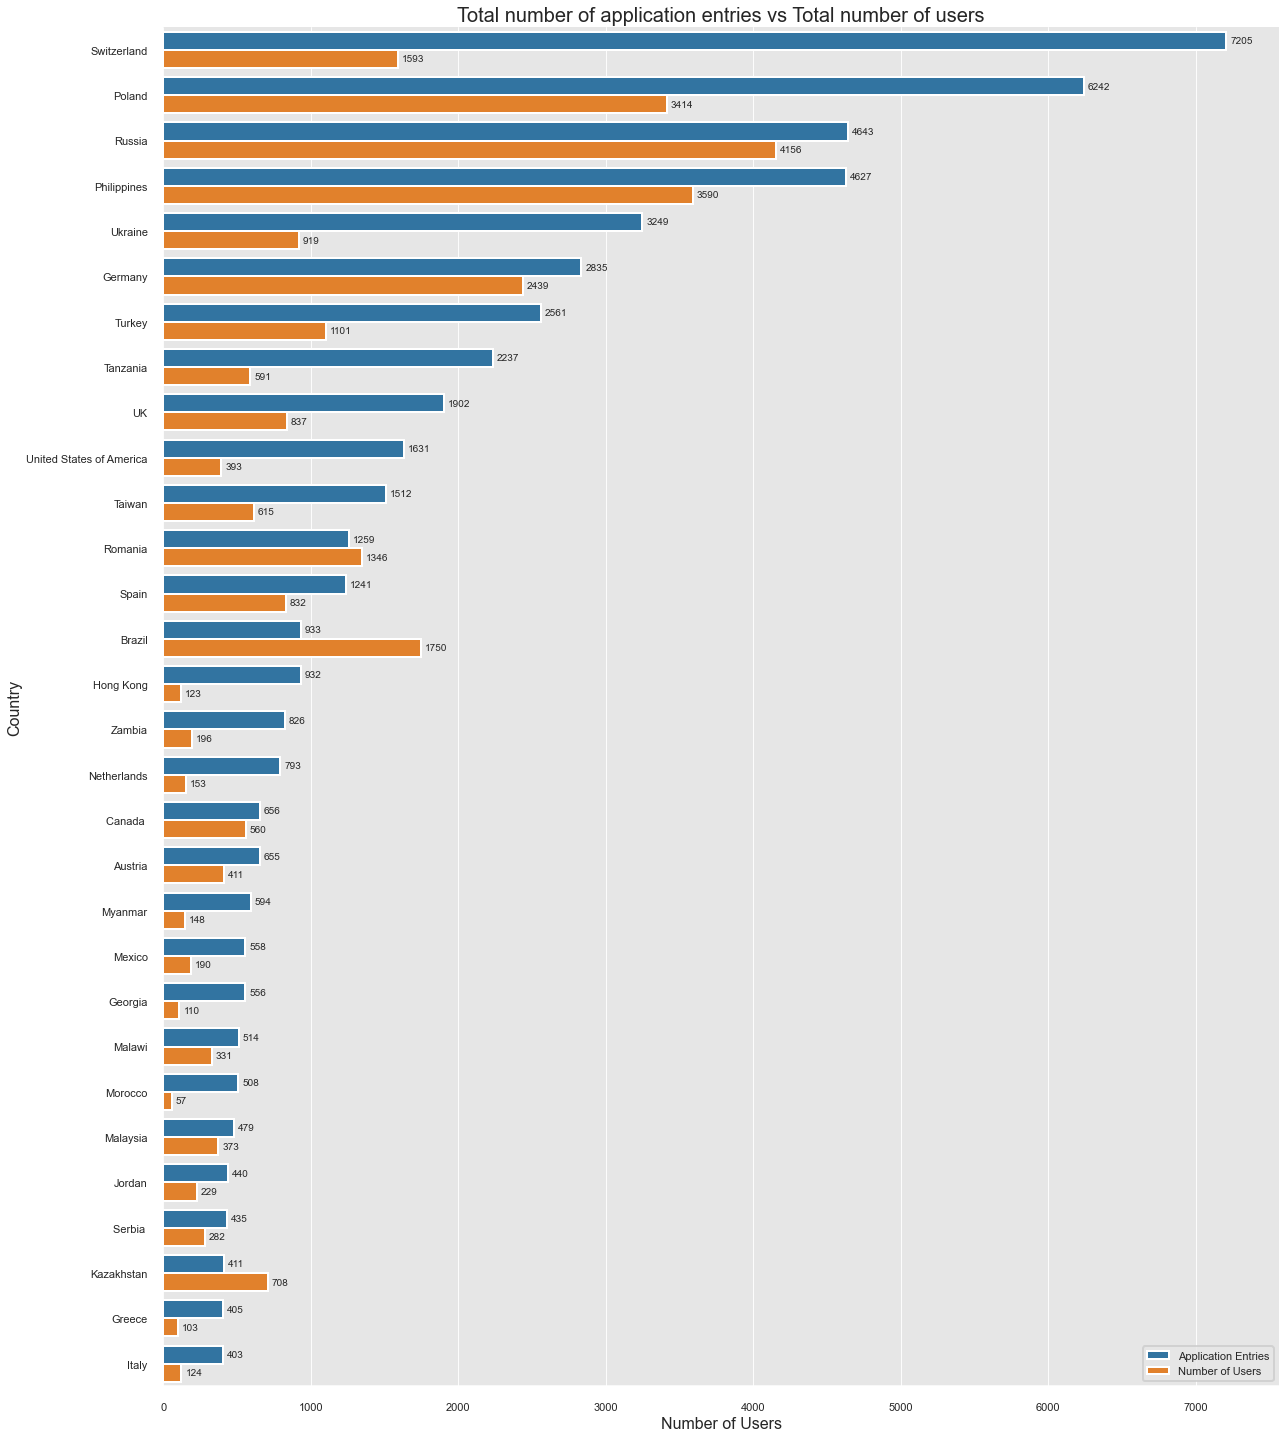

In [215]:
fig1, ax = plt.subplots(figsize=(20,25))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.9})

hue_order = ['Application Entries', 'Number of Users']

s = sns.barplot(x='value', y='Country', data=df_company_users_country_2, hue='variable', hue_order=hue_order)

ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=4, fontsize=10)
ax.bar_label(ax.containers[1], fmt='%.0f', label_type='edge', padding=4, fontsize=10)

ax.set_title('Total number of application entries vs Total number of users', fontsize=20)
ax.set_ylabel('Country', fontsize=16)
ax.set_xlabel('Number of Users', fontsize=16)
ax.legend(ncol=1, loc="best")
sns.despine(left=True)

### Analyze how many useres generate number of entries per country

In [217]:
df_company_users_country_trafic_1 = df_final.groupby(['code_payee', 'Country'])['code_payee'].count().reset_index(name='count')

# df_company_users_country_trafic_1.loc[df_company_users_country_trafic_1['Country']=='Poland']


In [218]:
df_company_users_country_trafic_1 = df_company_users_country_trafic_1.groupby('Country').agg({'code_payee':'count', 'count':'sum'}).sort_values('count', ascending=False).reset_index()

In [220]:
# df_company_users_country_trafic_1

In [221]:
df_company_users_country_trafic_2 = df_company_users_country.merge(df_company_users_country_trafic_1, left_on='Country', right_on='Country', how='left')

In [222]:
df_company_users_country_trafic_2.rename(columns={'code_payee':'Number of Users who Open Application', 'count':'Application Trafic'}, inplace=True)

In [223]:
df_company_users_country_trafic_2.sort_values('Application Trafic', ascending=False, inplace=True)

In [227]:
df_company_users_country_trafic_3 = df_company_users_country_trafic_2.head(30).melt(id_vars='Country', value_vars=['Application Trafic','Total Number of Users', 'Number of Users who Open Application'])

In [228]:
df_company_users_country_trafic_2['Application Trafic'].sum()

57515.0

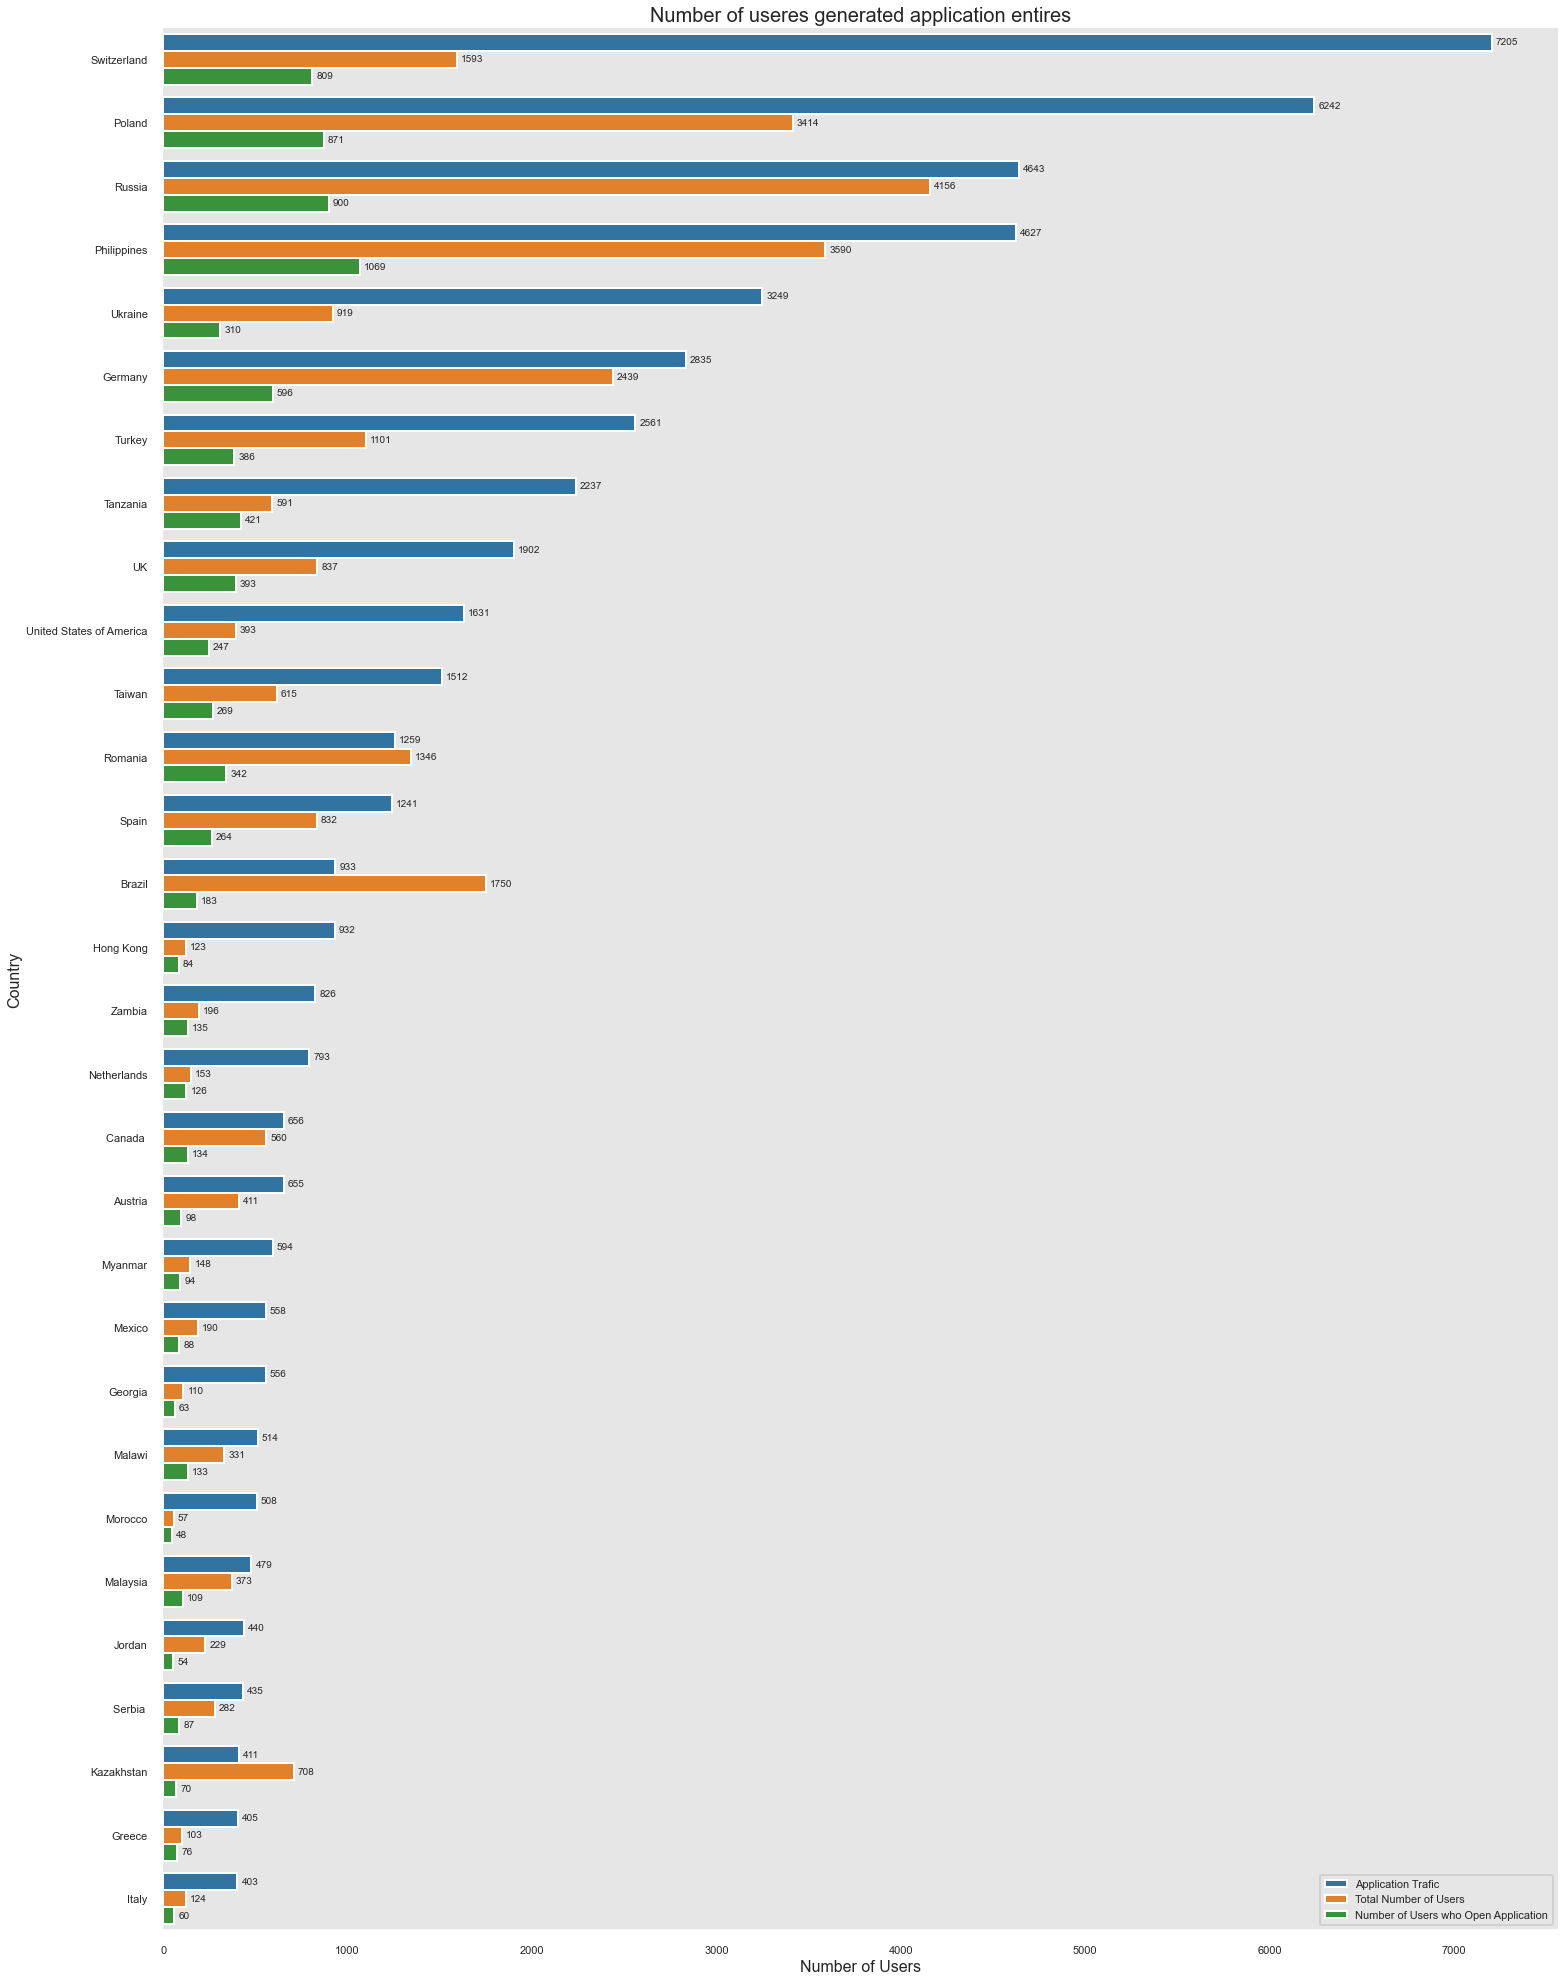

In [230]:
fig1, ax = plt.subplots(figsize=(25,35))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.04})
s = sns.barplot(x='value', y='Country', data=df_company_users_country_trafic_3, hue='variable')

ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=4, fontsize=10)
ax.bar_label(ax.containers[1], fmt='%.0f', label_type='edge', padding=4, fontsize=10)
ax.bar_label(ax.containers[2], fmt='%.0f', label_type='edge', padding=4, fontsize=10)

ax.set_title('Number of useres generated application entires', fontsize=20)
ax.set_ylabel('Country', fontsize=16)
ax.set_xlabel('Number of Users', fontsize=16)
ax.legend(ncol=1, loc="best")
sns.despine(left=True)

### Report. Overall application usage

In [231]:
df_application_usage = df_final[['Date', 'Region', 'Country','code_payee','IP' ]].copy().reset_index(drop=True).set_index('Date').sort_index()
df_application_usage = df_application_usage.resample('M')['Region'].count()

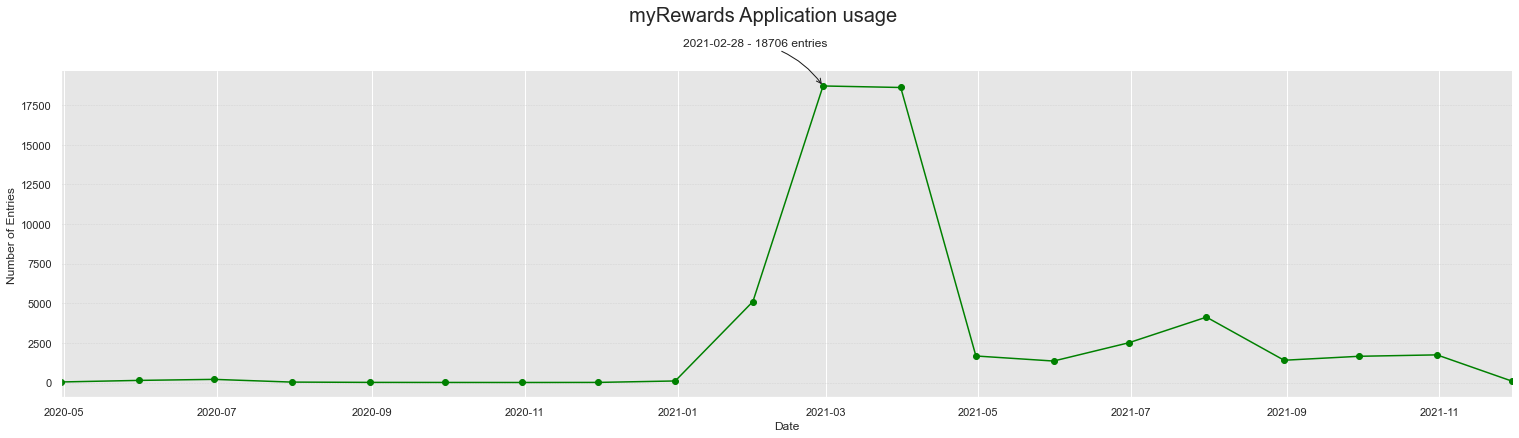

In [257]:
fig, ax = plt.subplots(figsize=(26,6))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("notebook")

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.annotate(
    (f"{str(df_application_usage.idxmax().date())} - {df_application_usage.max()} entries"),
    xy=(df_application_usage.idxmax(), df_application_usage.max()), xycoords='data',
    xytext=(-140, 40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",color='0.1',
                    connectionstyle="arc3,rad=-.2"))

plt.show()

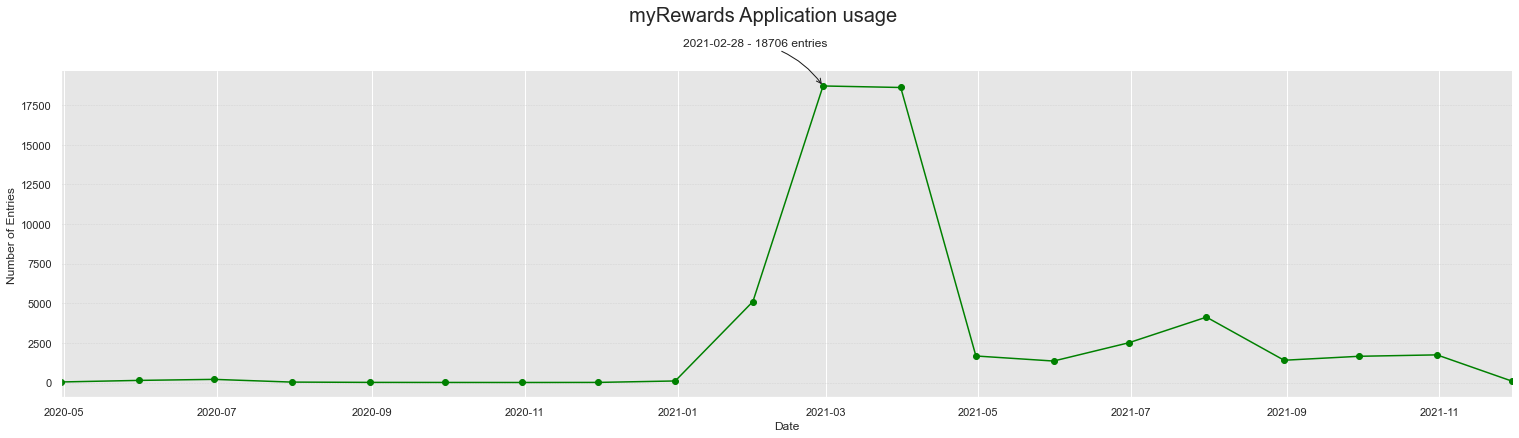

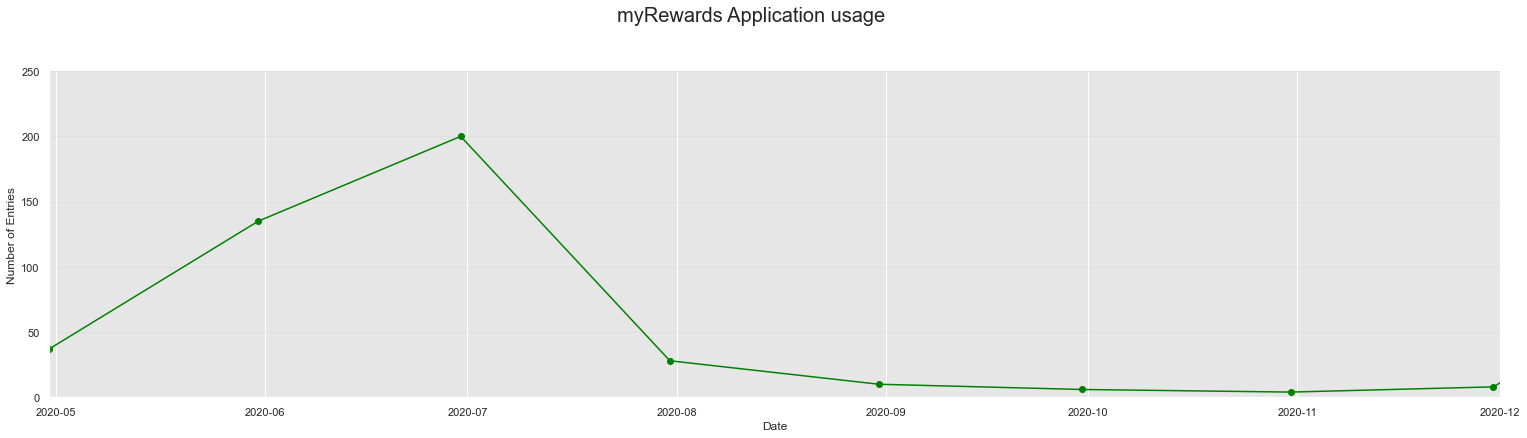

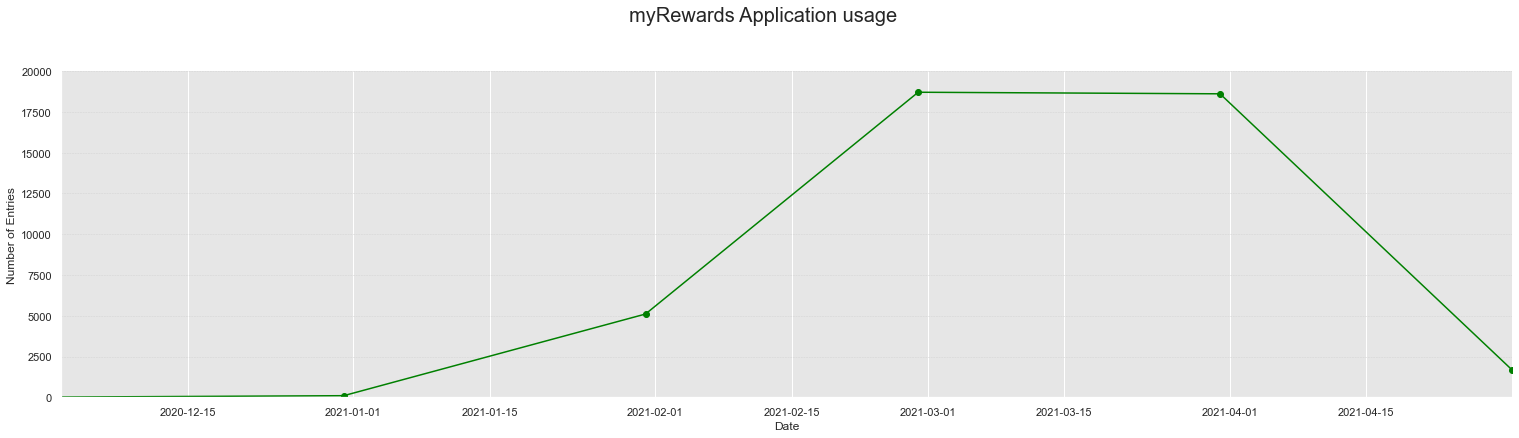

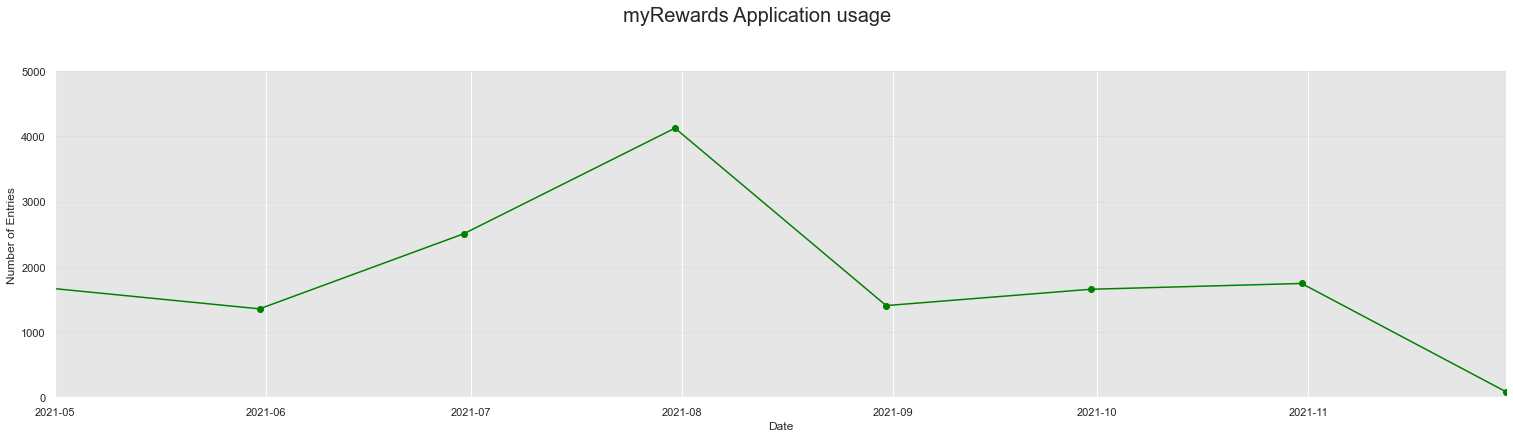

In [259]:
fig, ax = plt.subplots(figsize=(26,6))
sns.set_style('darkgrid', {'axes.facecolor':'.9'})
sns.set_context("notebook")

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.annotate(
    (f"{str(df_application_usage.idxmax().date())} - {df_application_usage.max()} entries"),
    xy=(df_application_usage.idxmax(), df_application_usage.max()), xycoords='data',
    xytext=(-140, 40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='0.1',
                    connectionstyle="arc3,rad=-.2"))


fig1, ax1 = plt.subplots(figsize=(26,6))

ax1.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax1.set_xlim(xmin=(df_application_usage.index.min()), xmax=(dt.date(2020,12,1)))
ax1.set_ylim(ymin=0, ymax=250)

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig1.suptitle('myRewards Application usage', size=20, y=1.03)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

fig2, ax2 = plt.subplots(figsize=(26,6))

ax2.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax2.set_xlim(xmin=(dt.date(2020,12,2)), xmax=(dt.date(2021,4,30)))
ax2.set_ylim(ymin=0, ymax=20000)

ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig2.suptitle('myRewards Application usage', size=20, y=1.03)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')


fig3, ax3 = plt.subplots(figsize=(26,6))

ax3.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax3.set_xlim(xmin=(dt.date(2021,5,1)), xmax=(df_application_usage.index.max()))
ax3.set_ylim(ymin=0, ymax=5000)

ax3.set_xlabel('Date')
ax3.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig3.suptitle('myRewards Application usage', size=20, y=1.03)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

(18748.0, 18961.0)

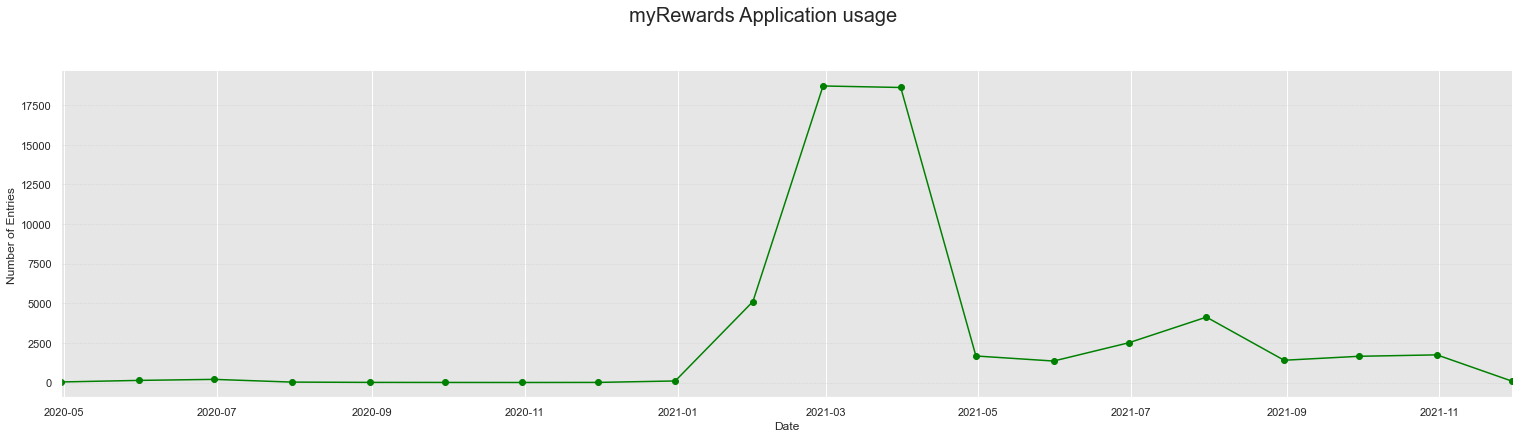

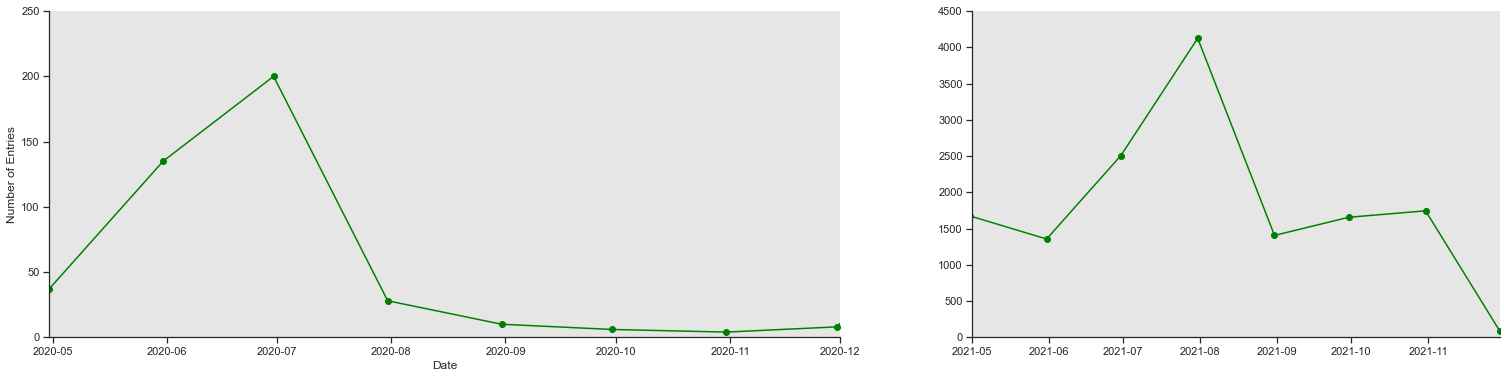

In [263]:
fig, ax = plt.subplots(figsize=(26,6))
sns.set_style('ticks', {'axes.facecolor':'.9'})
sns.set_context("notebook")

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(26,6), gridspec_kw={'width_ratios': [3,2]})
# gridspec_kw={'width_ratios': [3, 1]}

ax1.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax2.plot(df_application_usage, linewidth=1.5, color='green', marker='o')


ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Entries')
ax1.set_xlim(xmin=(df_application_usage.index.min()), xmax=(dt.date(2020,12,1)))  # outliers only
ax1.set_ylim(ymin=0, ymax=250)  # outliers only
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)



ax2.set_xlim(xmin=(dt.date(2021,5,1)), xmax=(df_application_usage.index.max()))  # outliers only
ax2.set_ylim(ymin=0, ymax=4500)  # outliers only
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_xlim(xmin=(dt.date(2021,5,1)), xmax=((df_application_usage.index.max())))   # most of the data


### myRewards application usage per Region

In [261]:
# df_prod = df_logs_all.loc[df_logs_all['Tenant'] == 'jti.9r1.prod.bqm'].reset_index(drop=True)
df_region_usage = df_final.reset_index(drop=True)
df_region_usage.groupby(['Date', 'Region'])['Region'].count()

Date                 Region        
2020-04-16 06:13:08  Eastern Europe    1
2020-04-16 14:08:53  Eastern Europe    1
2020-04-16 14:10:26  Eastern Europe    1
2020-04-16 14:11:14  Eastern Europe    1
2020-04-17 06:07:53  Eastern Europe    1
                                      ..
2021-11-02 12:06:36  Eastern Europe    1
2021-11-02 12:07:35  Eastern Europe    1
2021-11-02 12:07:39  Eastern Europe    1
2021-11-02 12:08:51  Eastern Europe    1
2021-11-02 12:38:59  MENEAT & WWDF     1
Name: Region, Length: 55423, dtype: int64

In [265]:
df_region_usage = df_region_usage.dropna()

In [266]:
plot_Americas = df_region_usage[df_region_usage['Region'].str.contains('Americas')].set_index('Date').resample('M')['Region'].count()

plot_AsiaPacific = df_region_usage[df_region_usage['Region'].str.contains('Asia Pacific')].set_index('Date').resample('M')['Region'].count()

plot_EasternEurope = df_region_usage[df_region_usage['Region'].str.contains('Eastern Europe')].set_index('Date').resample('M')['Region'].count()

plot_HQ = df_region_usage[df_region_usage['Region'].str.contains('HQ')].set_index('Date').resample('M')['Region'].count()

plot_MENEAT_WWDF = df_region_usage[df_region_usage['Region'].str.contains('MENEAT & WWDF')].set_index('Date').resample('M')['Region'].count()

plot_WesternEurope = df_region_usage[df_region_usage['Region'].str.contains('Western Europe')].set_index('Date').resample('M')['Region'].count()

In [267]:
df_region_usage['Date'].max()

Timestamp('2021-11-02 12:38:59')

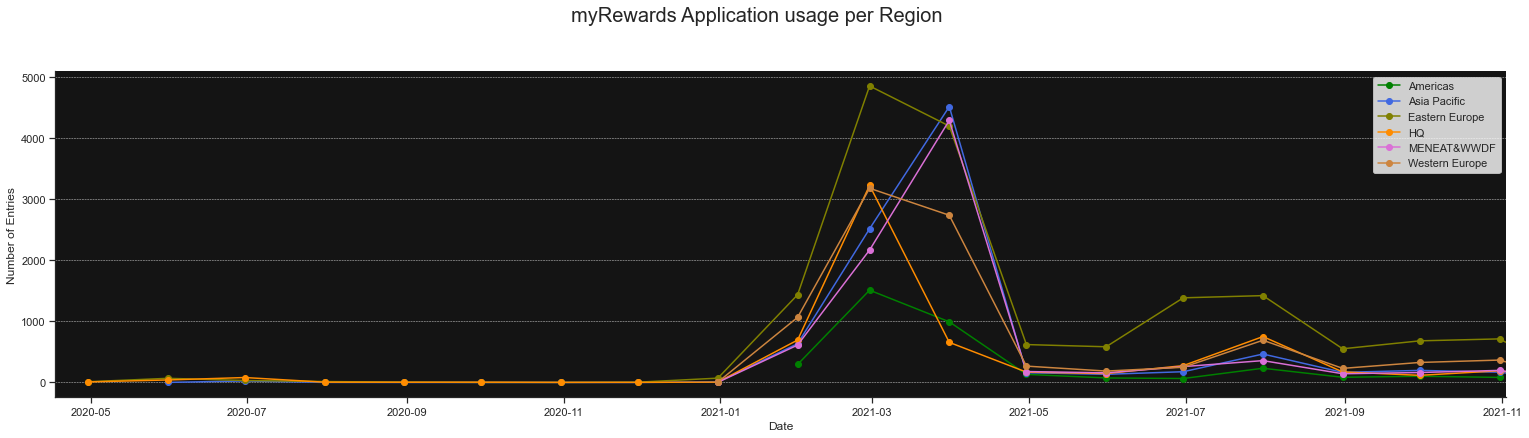

In [283]:
fig, ax = plt.subplots(figsize=(26,6))
sns.set_style('ticks', {'axes.facecolor':'1'})
sns.set_context("notebook")

line_americas = ax.plot(plot_Americas, linewidth=1.5, color='green', marker='o', label='Americas')
line_AsiaPacific = ax.plot(plot_AsiaPacific, linewidth=1.5, color='royalblue', marker='o', label='Asia Pacific')
line_EasternEurope = ax.plot(plot_EasternEurope, linewidth=1.5, color='olive', marker='o', label='Eastern Europe')
line_HQ = ax.plot(plot_HQ, linewidth=1.5, color='darkorange', marker='o', label='HQ')
line_MENEATWWDF = ax.plot(plot_MENEAT_WWDF, linewidth=1.5, color='orchid', marker='o', label='MENEAT&WWDF')
line_WesternEurope = ax.plot(plot_WesternEurope, linewidth=1.5, color='peru', marker='o', label='Western Europe')

ax.set_xlim(xmin=(df_region_usage['Date'].min()), xmax=(df_region_usage['Date'].max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage per Region', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.legend()


### Application usage heatmap

In [270]:
df_day_heatmap= df_final[['Date', 'Region', 'Country','code_payee','IP' ]].copy().reset_index(drop=True)

In [271]:
# df_day_heatmap['weekday'] = df_day_heatmap['Date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
df_day_heatmap['year'] = pd.DatetimeIndex(df_day_heatmap['Date']).year
df_day_heatmap['month'] = df_day_heatmap['Date'].dt.month_name()
df_day_heatmap['weekday'] = df_day_heatmap['Date'].dt.day_name()

In [272]:
df_day_heatmap_1 = df_day_heatmap.groupby(['month' , 'weekday']).size()
df_day_heatmap_1

month      weekday  
April      Friday       339
           Monday       315
           Saturday      48
           Sunday        41
           Thursday     364
                       ... 
September  Saturday      21
           Sunday        39
           Thursday     332
           Tuesday      305
           Wednesday    387
Length: 79, dtype: int64

In [273]:
df_day_heatmap_2 = df_day_heatmap_1.rename_axis(['Month', 'Weekday']).unstack('Weekday')

In [274]:
df_day_heatmap_2

Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Month,,,,,,,
April,339.0,315.0,48.0,41.0,364.0,311.0,310.0
August,201.0,371.0,21.0,54.0,228.0,310.0,280.0
December,17.0,17.0,NaN,NaN,34.0,19.0,12.0
February,4165.0,4094.0,346.0,414.0,3561.0,3234.0,2993.0
January,1611.0,976.0,132.0,256.0,713.0,723.0,719.0
July,388.0,2044.0,64.0,68.0,496.0,756.0,457.0
June,428.0,347.0,52.0,63.0,417.0,732.0,684.0
March,1923.0,5322.0,239.0,190.0,2157.0,4839.0,3964.0
May,269.0,312.0,32.0,55.0,307.0,270.0,256.0


In [275]:
# Replace NaN values to Zero
df_day_heatmap_2 = df_day_heatmap_2.fillna(0)

In [276]:
df_day_heatmap_2 = df_day_heatmap_2[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',]]
df_day_heatmap_2

Weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Month,,,,,,,
April,315.0,311.0,310.0,364.0,339.0,48.0,41.0
August,371.0,310.0,280.0,228.0,201.0,21.0,54.0
December,17.0,19.0,12.0,34.0,17.0,0.0,0.0
February,4094.0,3234.0,2993.0,3561.0,4165.0,346.0,414.0
January,976.0,723.0,719.0,713.0,1611.0,132.0,256.0
July,2044.0,756.0,457.0,496.0,388.0,64.0,68.0
June,347.0,732.0,684.0,417.0,428.0,52.0,63.0
March,5322.0,4839.0,3964.0,2157.0,1923.0,239.0,190.0
May,312.0,270.0,256.0,307.0,269.0,32.0,55.0


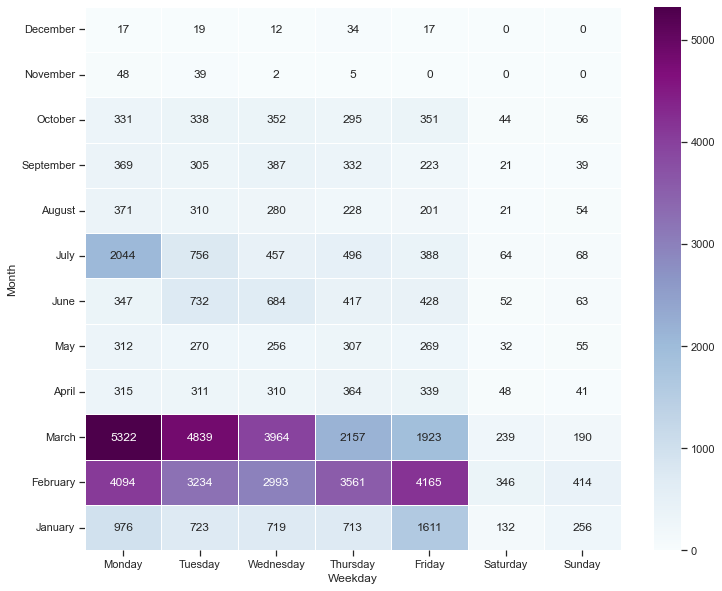

In [277]:
f, ax = plt.subplots(figsize=(12, 10))
df_day_heatmap_2.index = pd.CategoricalIndex(df_day_heatmap_2.index, categories= ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January'])
df_day_heatmap_2.sort_index(level=0, inplace=True)

heatmap_plot = sns.heatmap(df_day_heatmap_2, annot=True, fmt='.0f', linewidths=.5, cmap='BuPu')
#cmap="Greens"
#cmap="Blues"
#cmap="YlGnBu"